In [102]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools
from datetime import date
import calendar

In [103]:
train_df = pd.read_excel('2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_문제데이터.xlsx')
add_df = pd.read_excel('2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_자율평가데이터.xlsx')
test_df = pd.read_excel('2021 빅콘테스트_데이터분석분야_챔피언리그_수산Biz_평가데이터.xlsx')

# 1. 데이터 구축

In [104]:
# 날짜 변수 추가
train_df_EDA = train_df.copy()
train_df_EDA['year'] = train_df_EDA['REG_DATE'].dt.year
train_df_EDA['month'] = train_df_EDA['REG_DATE'].dt.month
train_df_EDA['day'] = train_df_EDA['REG_DATE'].dt.day
train_df_EDA['dayofweek'] = train_df_EDA['REG_DATE'].dt.dayofweek #ㅁ요일 (월 = 0)

In [105]:
# 품목별 데이터 발췌
train_df_squid = train_df_EDA.loc[train_df_EDA['P_NAME'] == '오징어']
train_df_salmon = train_df_EDA.loc[train_df_EDA['P_NAME'] == '연어']
train_df_shrimp = train_df_EDA.loc[train_df_EDA['P_NAME'] == '흰다리새우']

In [106]:
train_df_squid.head()

,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE,year,month,day,dayofweek
46,2015-12-28,수산물,대만,대만,판매용,연체류 해물모듬,오징어,오징어,"냉동,동체",1.989999,2015,12,28,0
94,2015-12-28,수산물,중국,중국,판매용,연체류 해물모듬,오징어,오징어,"냉동,동체",0.793729,2015,12,28,0
119,2015-12-28,수산물,페루,페루,판매용,연체류 해물모듬,오징어,오징어,"냉동,다리",1.233434,2015,12,28,0
143,2015-12-28,수산물,페루,페루,판매용,연체류 해물모듬,오징어,오징어,"냉동,동체,자숙",5.481140,2015,12,28,0
160,2015-12-28,수산물,칠레,칠레,판매용,연체류 해물모듬,오징어,오징어,"냉동,다리",0.968083,2015,12,28,0


# 2. EDA (기간별)

In [122]:
# 생산량 흐름 파악
def count_flow(data):
    for i, col in enumerate(['year', 'month', 'day', 'dayofweek']):
        plt.figure(figsize=(8,30))
        ax = plt.subplot(4,1, i+1)
        sns.distplot(x=data[col], hist=True, kde=True, rug=True)
        plt.xticks(rotation='vertical')
        plt.xlabel("%s" % col,  fontsize=12)  
        plt.ylabel('COUNT', fontsize=12) # 발생 횟수
    return plt.show()

# 가격과 생산량 비교
def price_count(data):
    f, ax = plt.subplots(4,2,figsize=(16,25))
    for i, col in enumerate(['year', 'month', 'day', 'dayofweek']):
        sns.barplot(x=col, y='P_PRICE', data=data, ax=ax[i,0])
        plt.xticks(rotation='vertical')
        sns.countplot(col, data=data, ax=ax[i,1])
        plt.xticks(rotation='vertical')
        plt.xlabel("%s" % col,  fontsize=12)  
        if i % 2 == 0 :
            plt.ylabel('Mean Price', fontsize=12) # 평균 가격
        else : 
            plt.ylabel('Sold Count', fontsize=12) # COUNT

## 2.1 전체 품목 EDA

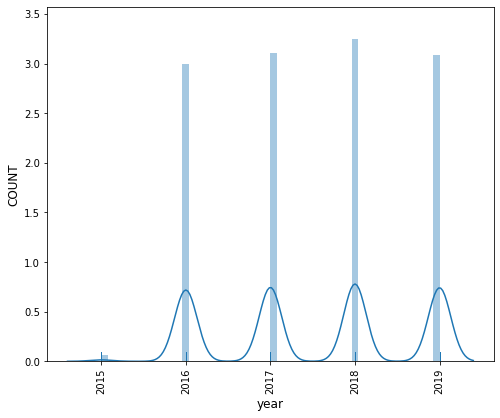

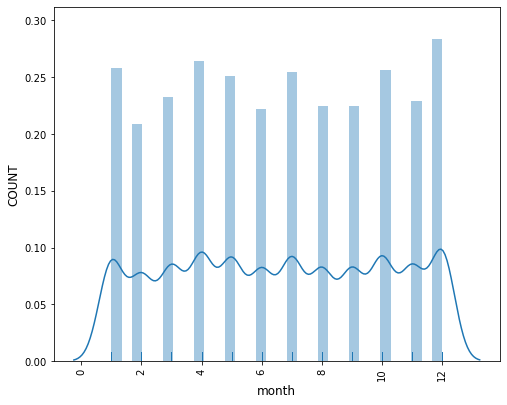

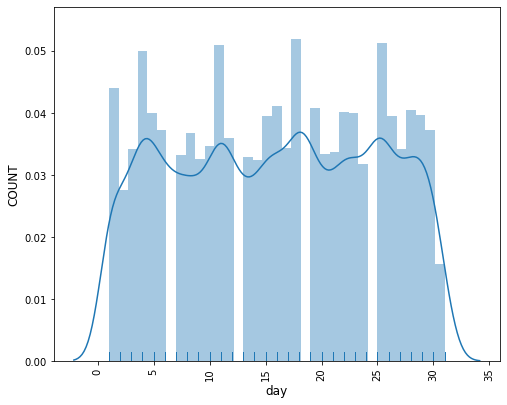

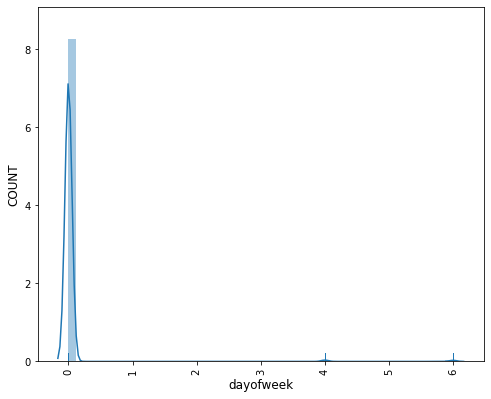

In [123]:
count_flow(train_df_EDA)

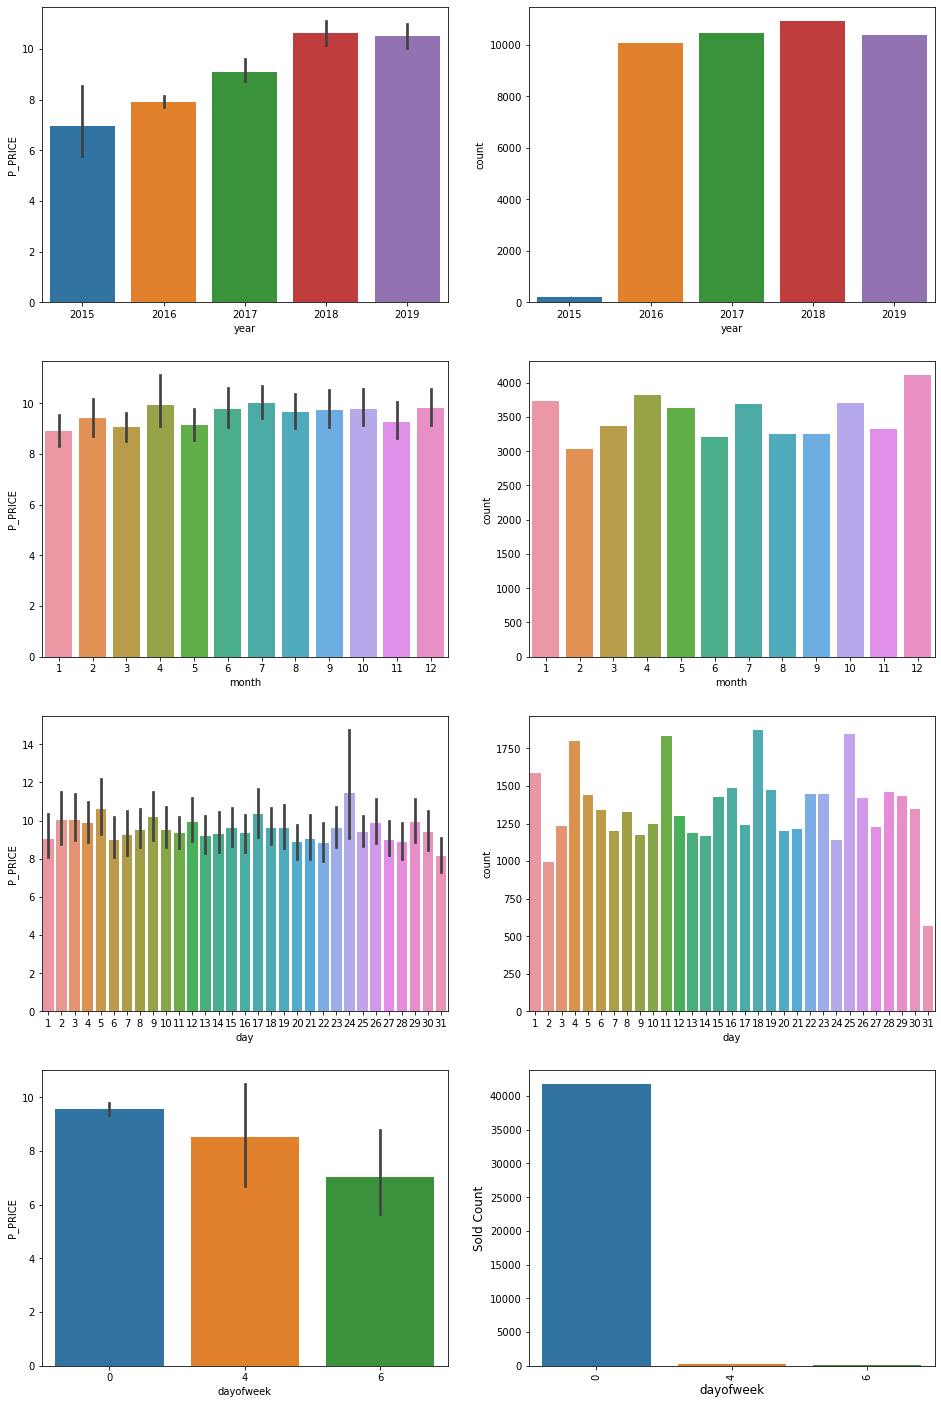

In [124]:
price_count(train_df_EDA)

## 2.2 연어 EDA

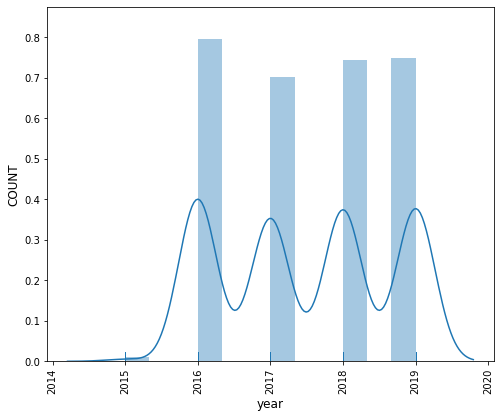

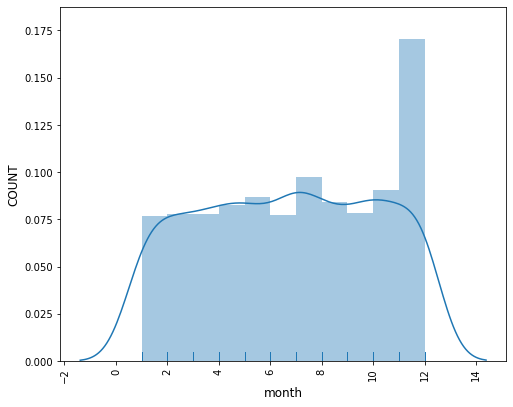

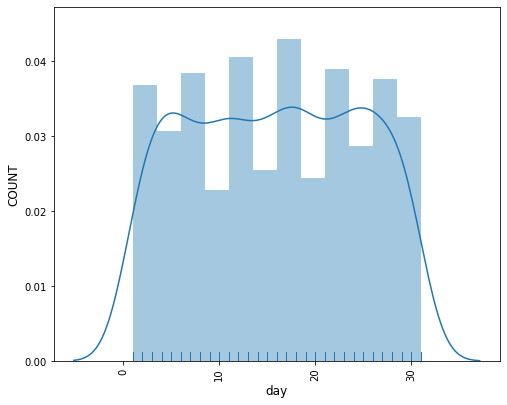

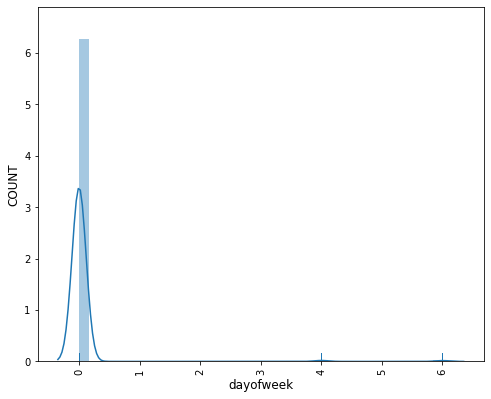

In [125]:
count_flow(train_df_salmon)

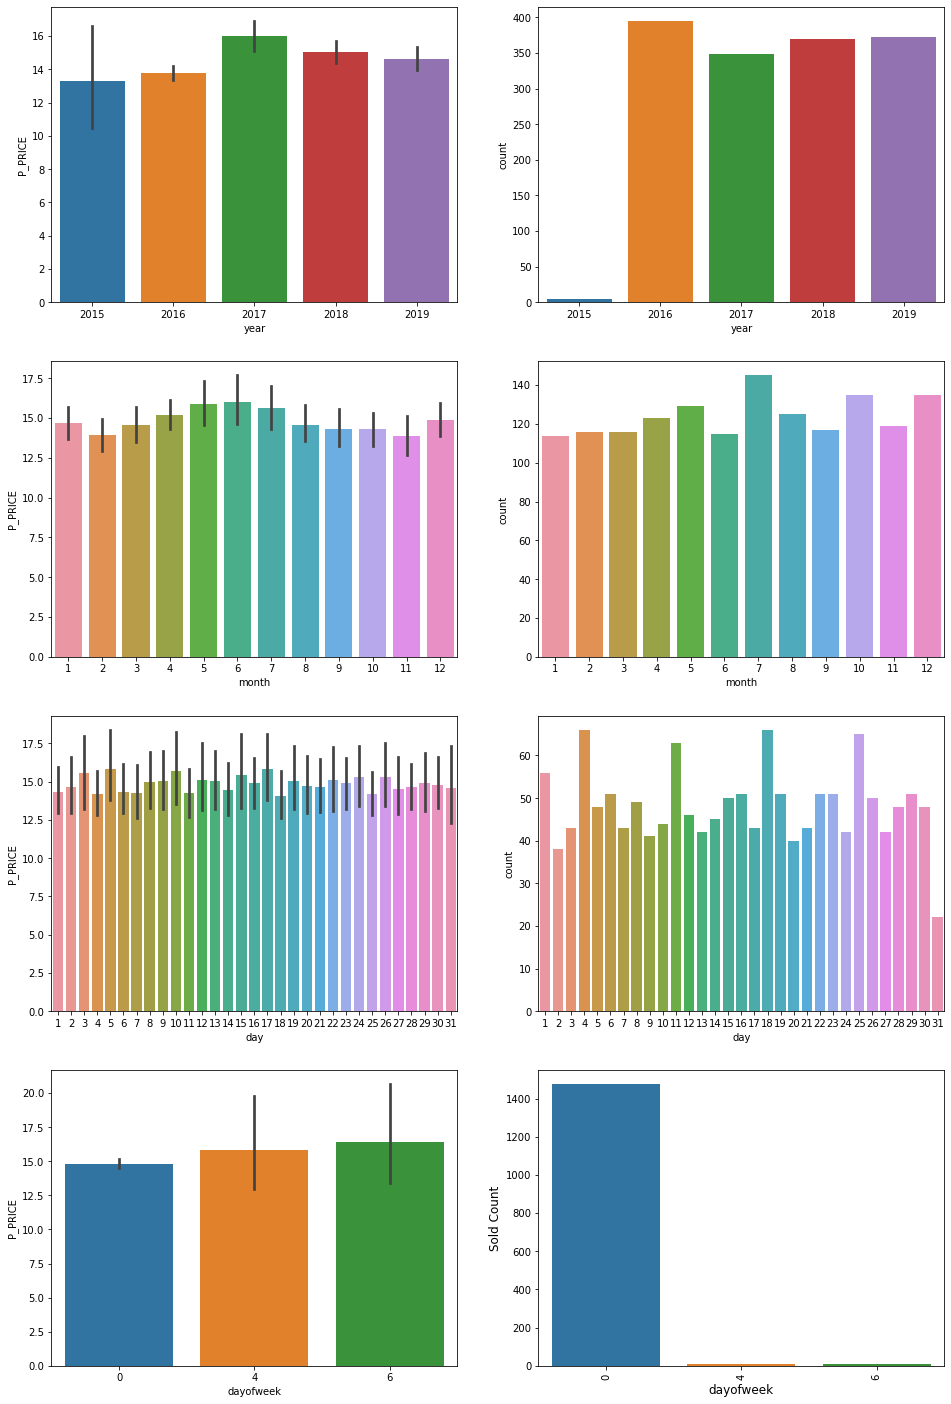

In [126]:
price_count(train_df_salmon)

## 2.3 오징어 EDA

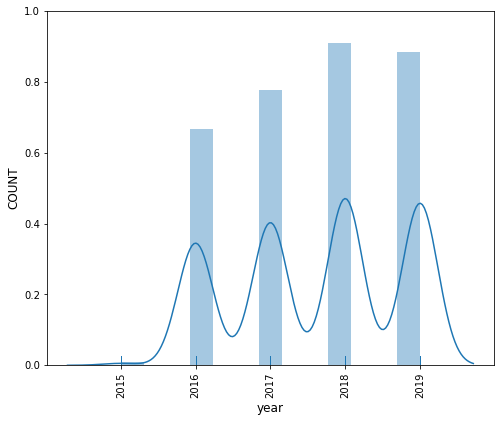

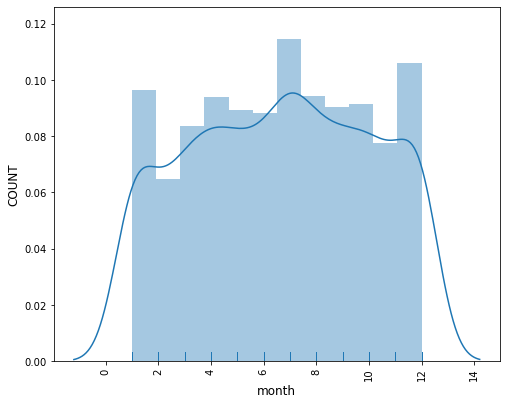

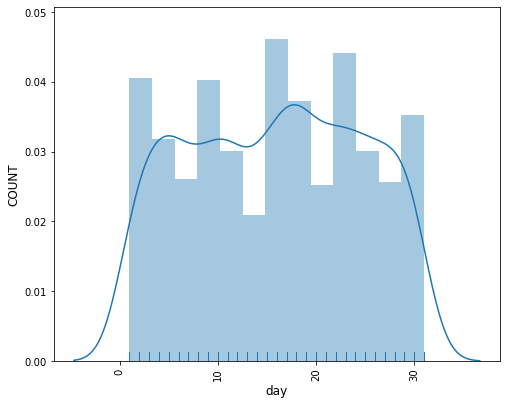

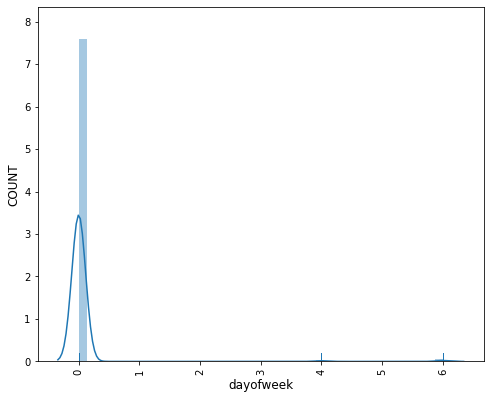

In [127]:
count_flow(train_df_squid)

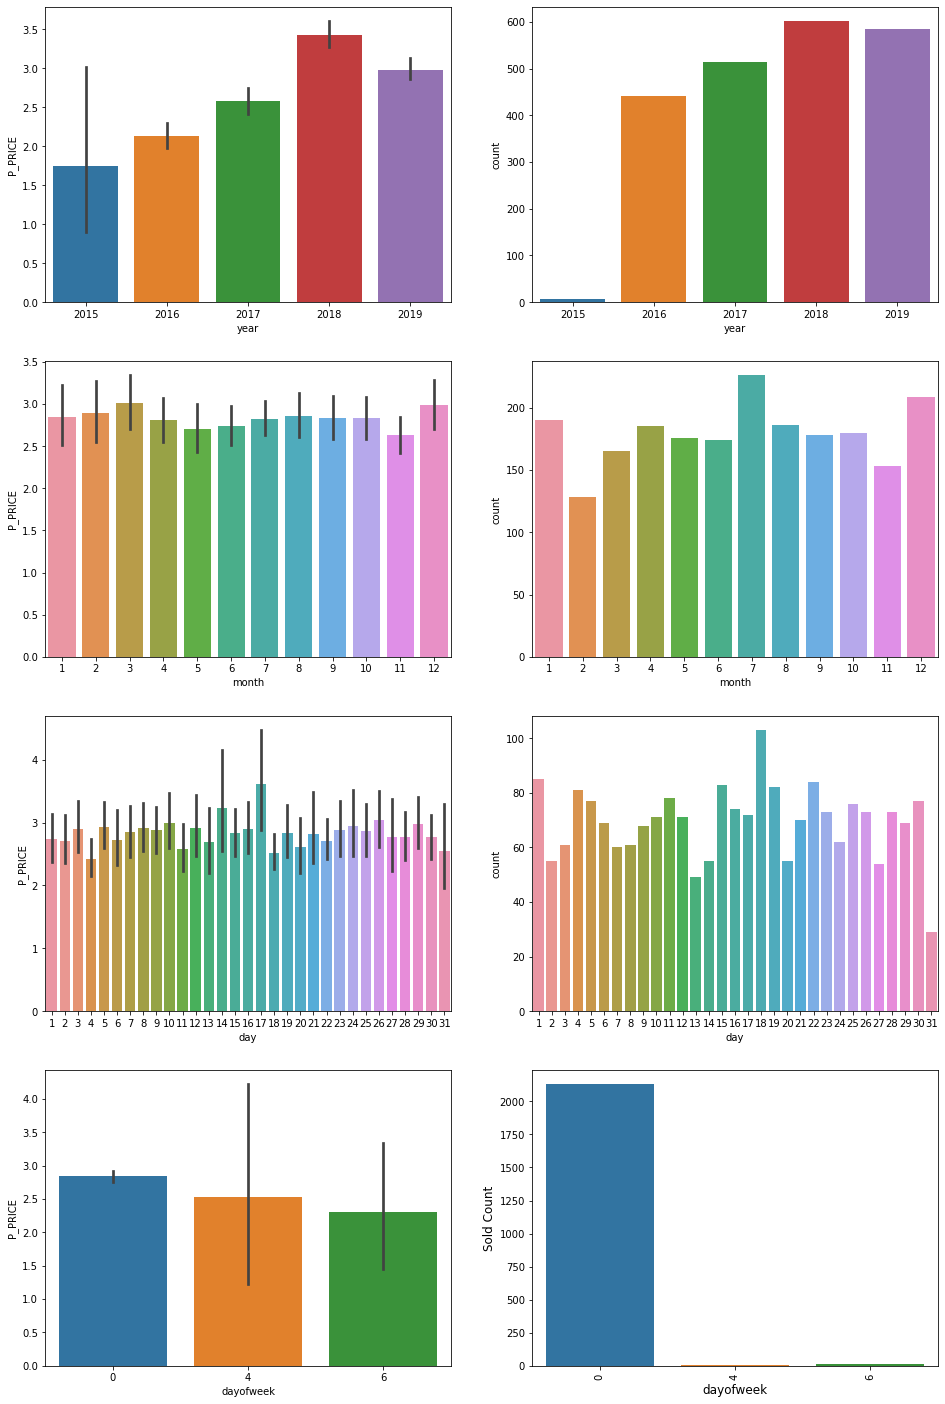

In [128]:
price_count(train_df_squid)

## 2.4 흰다리새우 EDA

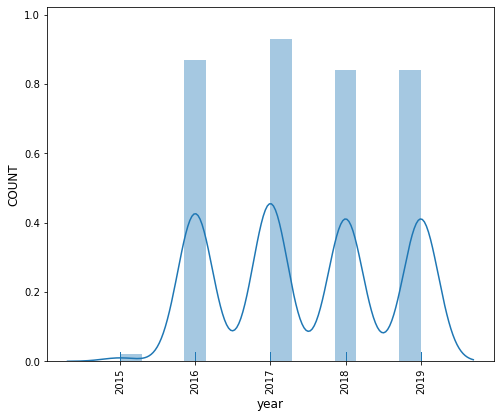

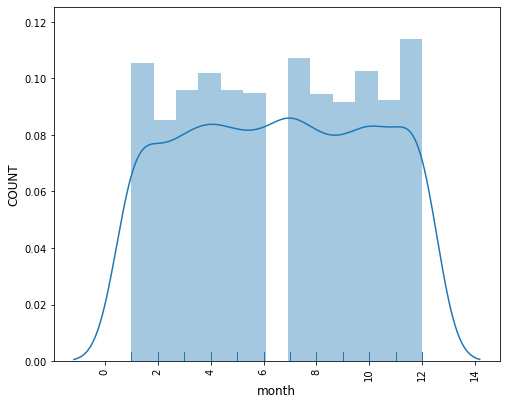

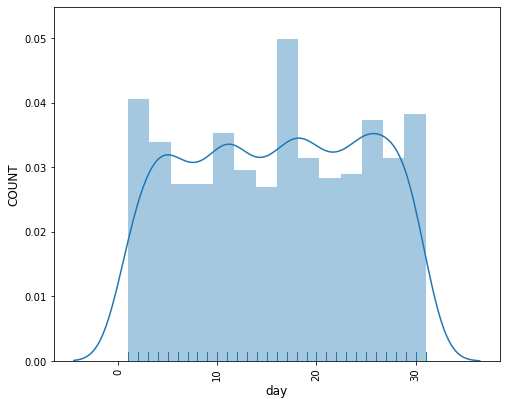

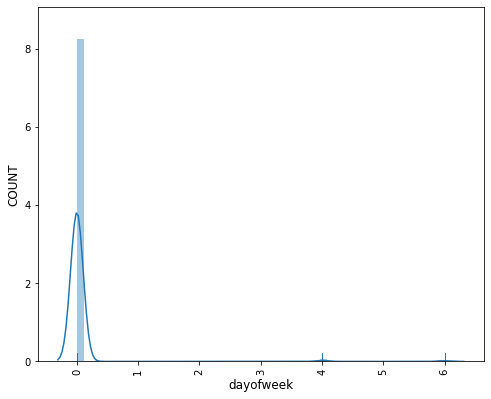

In [129]:
count_flow(train_df_shrimp)

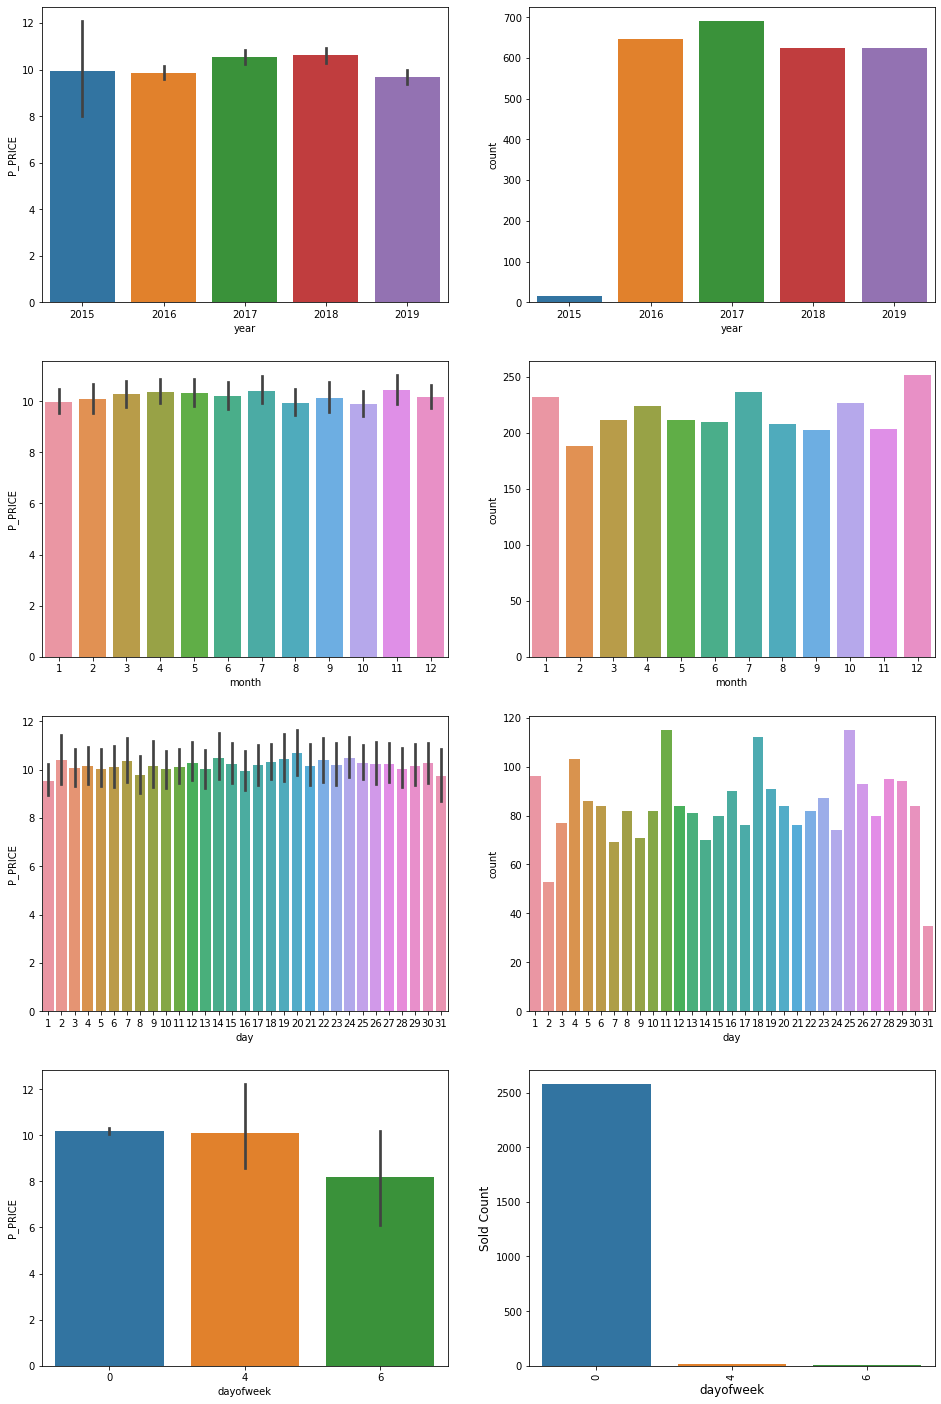

In [130]:
price_count(train_df_shrimp)

# 3. 시계열 모델 사용 조건 : 정상성 만족
1. 연어, 오징어, 흰다리새우 데이터에 대해 adfuller 정상성 검정 시행 
> **통계적 검증방법**

2. 연어, 오징어, 흰다리새우 데이터에 대해 ACF, PACF Plot 확인 
> **정성적 검증방법**

In [107]:
# 시계열분석 모델용 Data Preparation
def prepare_df_arima(df, subject):
    # 품목별 저장
    df = train_df.loc[train_df['P_NAME'] == subject]
    arima_df = df.groupby('REG_DATE').mean()
    
    return arima_df

In [108]:
# 연어, 오징어, 흰다리새우 주차별로 묶기 > 이후 시계열 모델에 사용
groupby_squid = prepare_df_arima(train_df, '오징어')
groupby_salmon = prepare_df_arima(train_df, '연어')
groupby_shrimp = prepare_df_arima(train_df, '흰다리새우')

In [109]:
groupby_squid.head()

,P_PRICE
REG_DATE,
2015-12-28,1.741647
2016-01-04,1.787152
2016-01-11,1.345855
2016-01-18,1.675178
2016-01-25,2.185579


## 3.1 adfuller 

In [110]:
# 정상성 검정 adf
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

In [111]:
# 연어의 adf
ad_test(groupby_salmon)

1. ADF :  -3.40231221052143
2. P-Value :  0.01088030060747892
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 206
5. Critical Values :
	 1% :  -3.4624988216864776
	 5% :  -2.8756749365852587
	 10% :  -2.5743041549627677


In [112]:
# 오징어의 adf
ad_test(groupby_squid)

1. ADF :  -2.2821894334544
2. P-Value :  0.17777658872526164
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression: 203
5. Critical Values :
	 1% :  -3.462980134086401
	 5% :  -2.875885461947131
	 10% :  -2.5744164898444515


In [113]:
# 흰다리새우의 adf
ad_test(groupby_shrimp)

1. ADF :  -3.8141973729275587
2. P-Value :  0.002765352088301456
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 206
5. Critical Values :
	 1% :  -3.4624988216864776
	 5% :  -2.8756749365852587
	 10% :  -2.5743041549627677


## 3.2 acf, pacf plot

In [114]:
def acf_pacf(data):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle('Raw Data')
    sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data.values.squeeze(), lags=40, ax=ax[1])

In [115]:
# 차분 진행 후 acf, pacf plot
def diff_acf_pacf(data):
    diff_data = data.copy()
    diff_data = diff_data.diff()
    diff_data = diff_data.dropna()

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle('Differenced Data')
    sm.graphics.tsa.plot_acf(diff_data.values.squeeze(), lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(diff_data.values.squeeze(), lags=40, ax=ax[1]);

### 연어 - acf, pacf

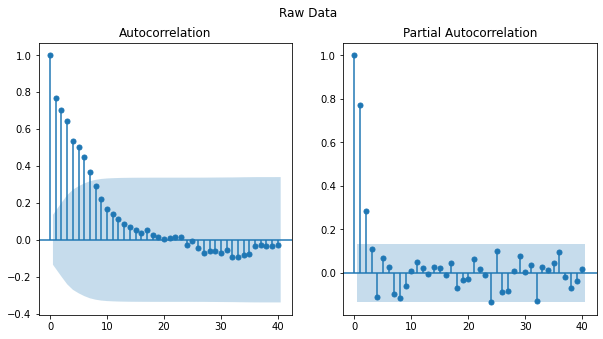

In [116]:
acf_pacf(groupby_salmon)

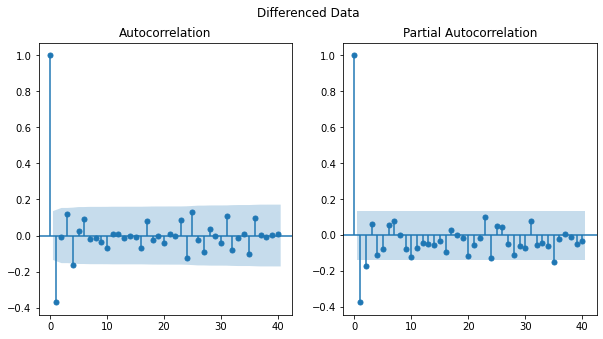

In [117]:
diff_acf_pacf(groupby_salmon)

### 오징어 - acf, pacf

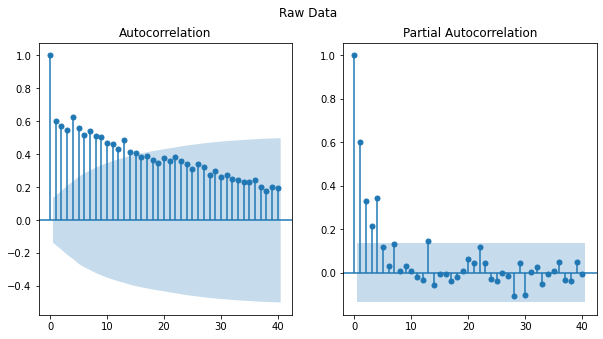

In [118]:
acf_pacf(groupby_squid)

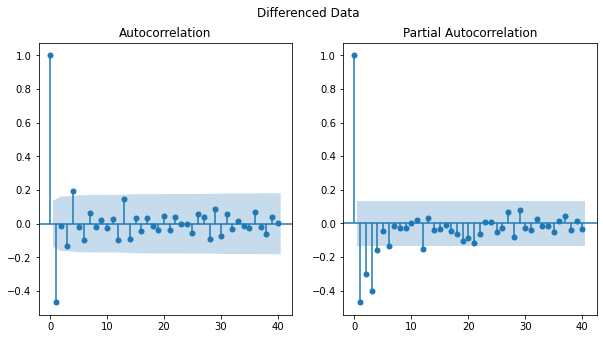

In [119]:
diff_acf_pacf(groupby_squid)

### 흰다리새우 - acf, pacf

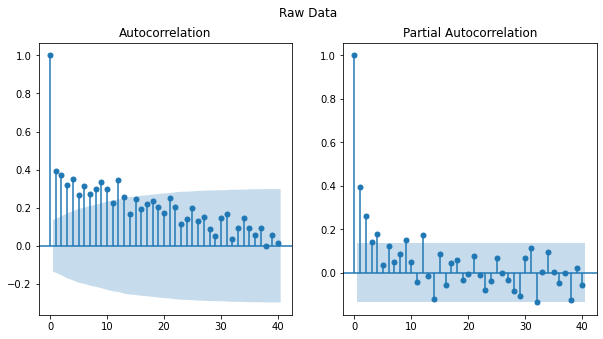

In [120]:
acf_pacf(groupby_shrimp)

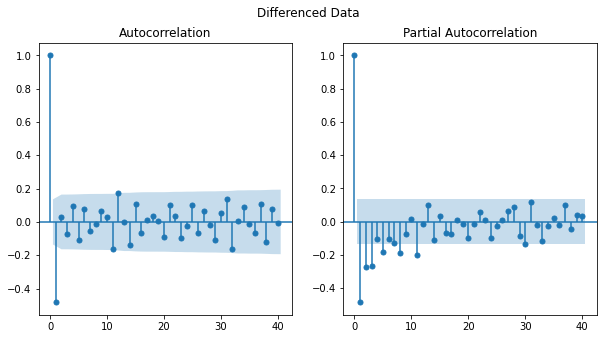

In [121]:
diff_acf_pacf(groupby_shrimp)

In [131]:
train_df_salmon

,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE,year,month,day,dayofweek
74,2015-12-28,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,필렛(F)",12.936815,2015,12,28,0
129,2015-12-28,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,포장횟감,필렛(F)",19.146755,2015,12,28,0
168,2015-12-28,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,필렛(F),횟감",12.082384,2015,12,28,0
174,2015-12-28,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,"냉장,필렛(F)",13.425826,2015,12,28,0
198,2015-12-28,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,냉장,8.844281,2015,12,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41994,2019-12-30,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,필렛(F)",16.495971,2019,12,30,0
41995,2019-12-30,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,필렛(F),횟감",18.350634,2019,12,30,0
42044,2019-12-30,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,냉장,11.128269,2019,12,30,0
42056,2019-12-30,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,"냉장,필렛(F)",15.631531,2019,12,30,0


# 4. 전처리 고려

In [150]:
def outlier(data, column):
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)  
    # IQR 계산하기     
    iqr = q75 - q25

    # outlier cutoff 계산하기 
    cut_off = iqr * 1.5  
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off 
    
    # boxplot
    plt.figure(figsize=(10,5))
    sns.distplot(data.P_PRICE, kde=False)

    # 이상치 영역 박스 그리기
    plt.axvspan(xmin=lower, xmax=data.P_PRICE.min(), alpha=0.2, color='red')
    plt.axvspan(xmin=upper, xmax=data.P_PRICE.max(), alpha=0.2, color='red')

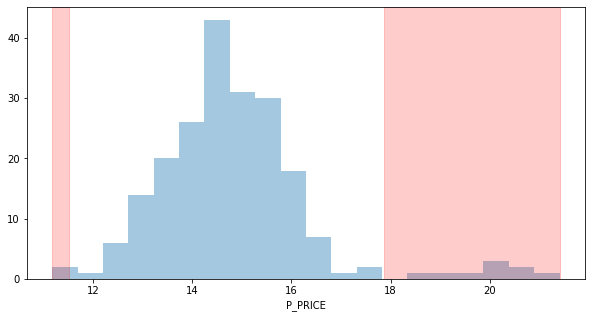

In [151]:
# 연어
outlier(groupby_salmon, 'P_PRICE')

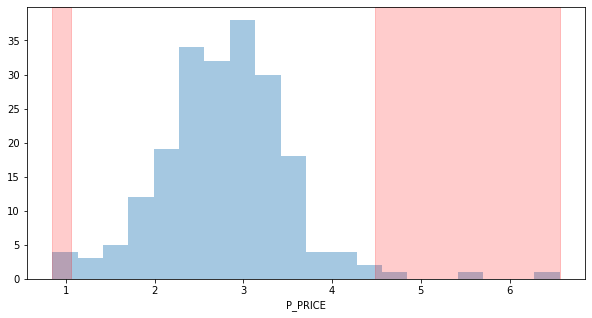

In [152]:
# 오징어
outlier(groupby_squid, 'P_PRICE')

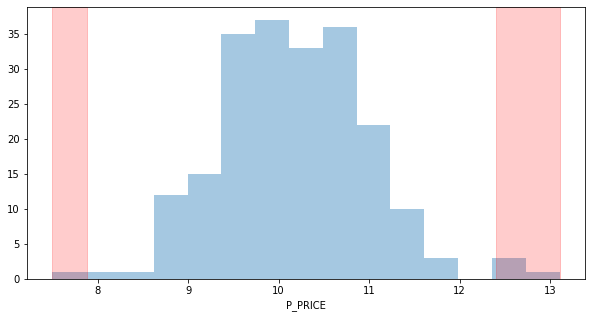

In [153]:
# 흰다리새우
outlier(groupby_shrimp, 'P_PRICE')

- 각 품목의 주차별 가격 데이터에서 이상치를 파악 결과, 빨간박스안에 품목별 빨간 박스안에 이상치가 보이긴 하나,
- 소비자물가지수(e나라지표), 어획량 변동에 따라 물가변동이 있을거라 판단
- 따라서 이상치를 제거하지 않기로 결정